## VAE Hawkes Process Estimation - Tutorial

In [2]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
from dl.lstm_model import LSTMTrainer
from dl.vae_model import VAETrainer
from dl.dueling_decoder import DuelingTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors, compute_nrmse, integrate_intensity
from hawkes.simulation import hawkes_simulations, randomized_mle
from hawkes.discretisation import discretise, jump_times
from hawkes.hyperparameters import exp_hyperparams, pow_hyperparams
from tools.utils import write_parquet, read_parquet, timer
from visualization.error_viz import convergence_rate, errors_boxplots, effects_boxplots, pred_boxplots, reconstruction_plot, nrmse_boxplot
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

### Preprocessing

In [96]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = exp_hyperparams(filename="all_models/hawkes_hyperparams_eta_0.8_delta_5.0.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(params={"mu": mu, "alpha": alpha, "beta": beta}, filename="all_models/hawkes_simulations_eta_0.8_delta_5.0.parquet")

# Discretized hawkes process
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="all_models/binned_hawkes_simulations_eta_0.8_delta_5.0.parquet")

### Training

In [2]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("all_models/binned_hawkes_simulations_train_delta_10.parquet")
y = read_parquet("all_models/hawkes_hyperparams_train_delta_10.parquet")

# train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, x) 
# train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, np.column_stack((x, y[['eta', 'mu']])))
train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[['eta', 'mu']])
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [3]:
# Trained models

# model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
model, train_losses, val_losses, val_y_pred, val_eta, val_mu = LSTMTrainer().train_model(train_loader, val_loader, val_x, val_y)

# model, train_losses, val_losses, val_x_pred = VAETrainer().train_model(train_loader, val_loader, val_x, val_y)
# model, train_losses, val_losses, val_x_pred = DuelingTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
LSTM                                     [10000, 10]               [10000, 2]                --                             --                   --                        --                        True
├─LSTM: 1-1                              [10000, 10]               [10000, 64]               52,736                     99.75%                   --                        33,751,040,000            True
├─Linear: 1-2                            [10000, 64]               [10000, 2]                130                         0.25%                   --                        1,300,000                 True
Total params: 52,866
Trainable params: 52,866
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 33.75
Input size (MB): 0.40
Forward/backward pass size (MB): 5.28
Params size (MB)

Epoch 500/500 - train_loss: 0.1684, val_loss: 0.1712: 100%|██████████| 500/500 [1:54:20<00:00, 13.72s/it]


Best model loading (2023_07_24_23_51_37_MICSHPEG8GIRARD_best_model.pt)...
Validation set - Estimated branching ratio (η): 0.4261, Estimated baseline intensity (µ): 2.8615


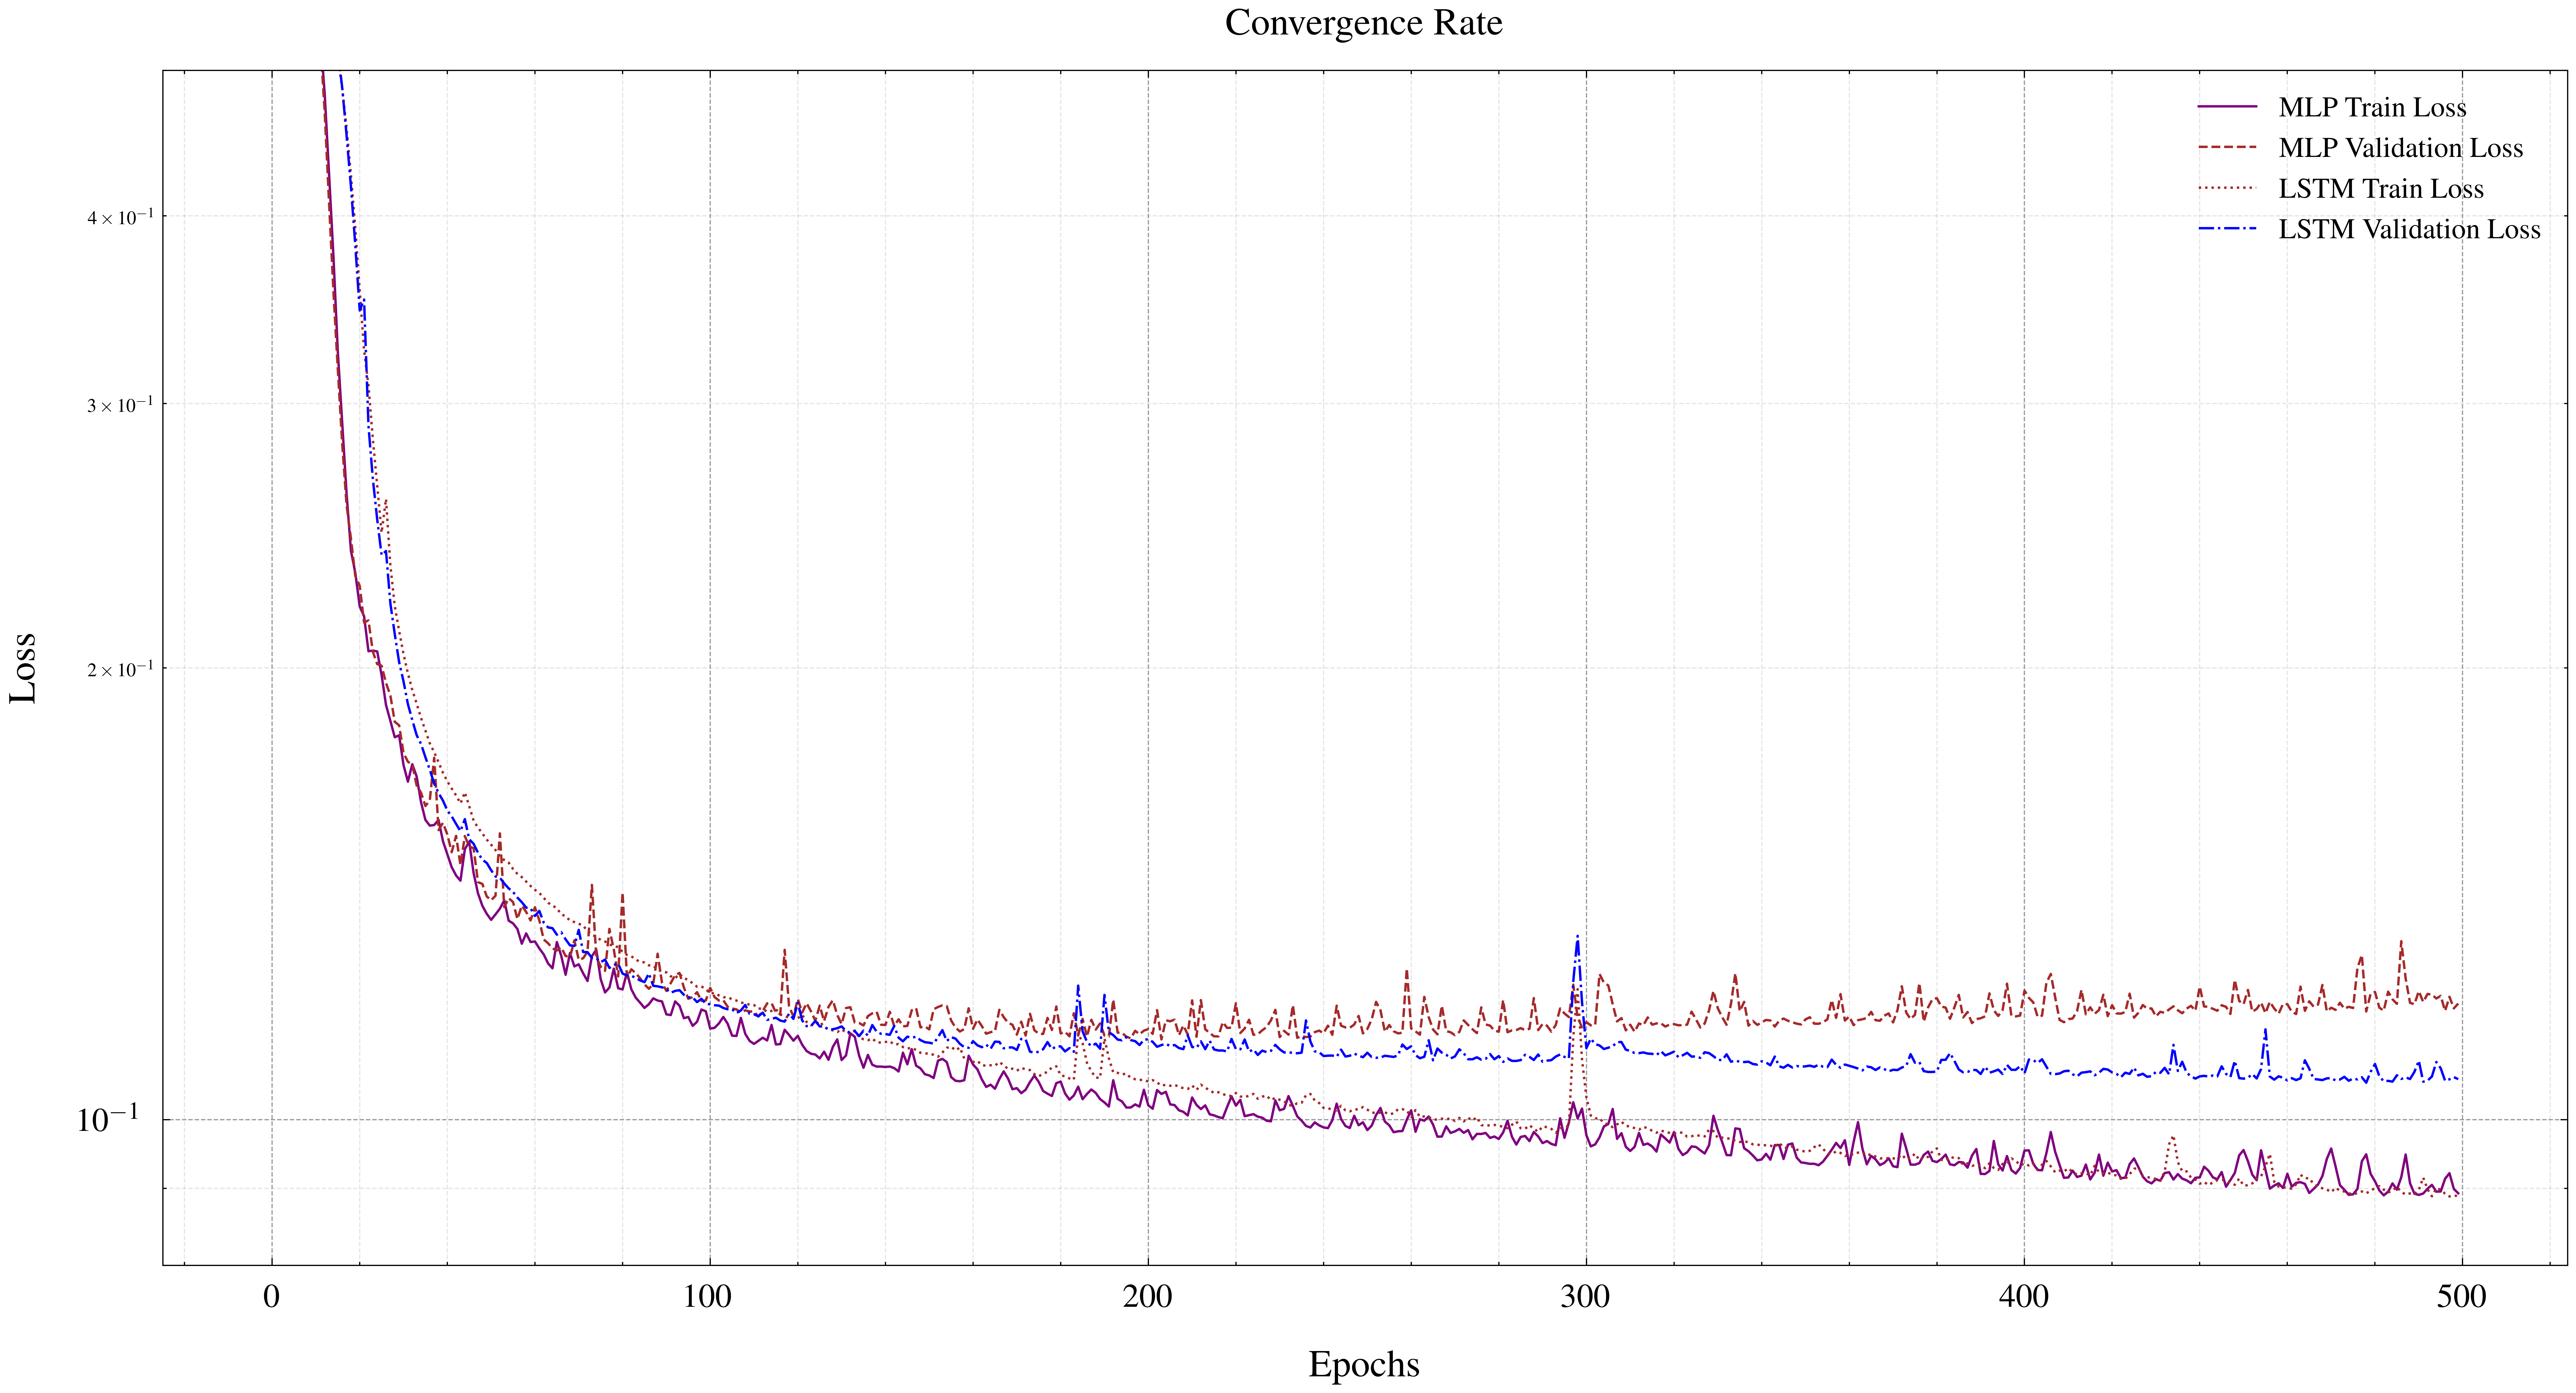

In [9]:
# Convergence rate plots

mlp_losses = read_parquet('mlp/losses_mlp.parquet')
lstm_losses = read_parquet('lstm/losses_lstm.parquet')

convergence_rate(losses=[mlp_losses, lstm_losses], models=["MLP", "LSTM"], colors=["purple", "brown", "blue", "red"], filename = "convergence_rate/convergence_rate_mlp_vs_lstm.pdf")

### Testing

In [100]:
# Tested models (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("all_models/binned_hawkes_simulations_eta_0.8_delta_2.0.parquet")
y = read_parquet("all_models/hawkes_hyperparams_eta_0.8_delta_2.0.parquet")

y_pred, eta_pred, mu_pred = randomized_mle(x.to_numpy(),  y[['eta']].to_numpy(), y[['mu']].to_numpy(), filename="all_models/predictions_mle_eta_0.8_delta_2.0.parquet")

# x = read_parquet("all_models/binned_hawkes_simulations_eta_0.8_delta_5.0.parquet")
# y = read_parquet("all_models/hawkes_hyperparams_eta_0.8_delta_5.0.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
# test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)

# x = read_parquet("all_models/binned_hawkes_simulations_eta_0.8_delta_5.0.parquet")
# y = read_parquet("all_models/hawkes_hyperparams_eta_0.8_delta_5.0.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
# test_y_pred, _, _ = LSTMTrainer().test_model(test_x, test_y)
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Evaluation

In [63]:
# Error / Relative error + Boxplots

# mle_hyperparams = read_parquet('mle/hawkes_hyperparams.parquet')
# mle_pred = read_parquet('mle/predictions_mle.parquet')

# mlp_hyperparams = read_parquet('mlp/hawkes_hyperparams_test.parquet')
# mlp_pred = read_parquet('mlp/predictions_mlp.parquet')

# lstm_hyperparams = read_parquet('lstm/hawkes_hyperparams_test.parquet')
# lstm_pred = read_parquet('lstm/predictions_lstm.parquet')

lstm_hyperparams_025 = read_parquet('activities_lstm/hawkes_hyperparams_actv_50.parquet')
lstm_hyperparams_05 = read_parquet('activities_lstm/hawkes_hyperparams_actv_100.parquet')
lstm_hyperparams_1 = read_parquet('activities_lstm/hawkes_hyperparams_actv_250.parquet')
lstm_hyperparams_2 = read_parquet('activities_lstm/hawkes_hyperparams_actv_500.parquet')
lstm_hyperparams_5 = read_parquet('activities_lstm/hawkes_hyperparams_actv_1000.parquet')

lstm_pred_025 = read_parquet('activities_lstm/predictions_lstm_actv_50.parquet')
lstm_pred_05 = read_parquet('activities_lstm/predictions_lstm_actv_100.parquet')
lstm_pred_1 = read_parquet('activities_lstm/predictions_lstm_actv_250.parquet')
lstm_pred_2 = read_parquet('activities_lstm/predictions_lstm_actv_500_bis.parquet')
lstm_pred_5 = read_parquet('activities_lstm/predictions_lstm_actv_1000.parquet')

# lstm_hyperparams_0525 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.1_0.4.parquet')
# lstm_hyperparams_1737 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.3_0.6.parquet')
# lstm_hyperparams_0305 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.5_0.8.parquet')
# lstm_hyperparams_0503 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.1_0.6.parquet')
# lstm_hyperparams_1504 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.2_0.7.parquet')
# lstm_hyperparams_2505 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.3_0.8.parquet')
# lstm_hyperparams_0504 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.05_0.6.parquet')
# lstm_hyperparams_1505 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.05_0.7.parquet')
# lstm_hyperparams_0505 = read_parquet('br_mle/hawkes_hyperparams_mle_br_0.05_0.8.parquet')

# lstm_beta_0525 = read_parquet('br_mle/predictions_mle_br_0.1_0.4.parquet')
# lstm_beta_1737 = read_parquet('br_mle/predictions_mle_br_0.3_0.6.parquet')
# lstm_beta_0305 = read_parquet('br_mle/predictions_mle_br_0.5_0.8.parquet')
# lstm_beta_0503 = read_parquet('br_mle/predictions_mle_br_0.1_0.6.parquet')
# lstm_beta_1504 = read_parquet('br_mle/predictions_mle_br_0.2_0.7.parquet')
# lstm_beta_2505 = read_parquet('br_mle/predictions_mle_br_0.3_0.8.parquet')
# lstm_beta_0504 = read_parquet('br_mle/predictions_mle_br_0.05_0.6.parquet')
# lstm_beta_1505 = read_parquet('br_mle/predictions_mle_br_0.05_0.7.parquet')
# lstm_beta_0505 = read_parquet('br_mle/predictions_mle_br_0.05_0.8.parquet')

# mle_errors = read_parquet('mle/errors_mle.parquet')
# mlp_errors = read_parquet('mlp/errors_mlp.parquet')
# lstm_errors = read_parquet('lstm/errors_lstm.parquet')

# mle_errors = compute_errors(mle_hyperparams[['eta', 'mu']], mle_pred[['eta_pred', 'mu_pred']], model_name="MLE", filename = "mle/errors_mle.parquet")
# mlp_errors = compute_errors(mlp_hyperparams[['eta', 'mu']], mlp_pred[['eta_pred', 'mu_pred']], model_name="MLP", filename = "mlp/errors_mlp.parquet")
# lstm_errors = compute_errors(lstm_hyperparams[['eta', 'mu']], lstm_pred[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "lstm/errors_lstm.parquet")

lstm_errors_025 = compute_errors(lstm_hyperparams_025[['eta', 'mu']], lstm_pred_025[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "activities_lstm/errors_lstm_actv_50.parquet")
lstm_errors_05 = compute_errors(lstm_hyperparams_05[['eta', 'mu']], lstm_pred_05[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "activities_lstm/errors_lstm_actv_100.parquet")
lstm_errors_1 = compute_errors(lstm_hyperparams_1[['eta', 'mu']], lstm_pred_1[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "activities_lstm/errors_lstm_actv_250.parquet")
lstm_errors_2 = compute_errors(lstm_hyperparams_2[['eta', 'mu']], lstm_pred_2[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "activities_lstm/errors_lstm_actv_500.parquet")
lstm_errors_5 = compute_errors(lstm_hyperparams_5[['eta', 'mu']], lstm_pred_5[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "activities_lstm/errors_lstm_actv_1000.parquet")

# lstm_errors_0525 = compute_errors(lstm_hyperparams_0525[['eta', 'mu']], lstm_beta_0525[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.1_0.4.parquet")
# lstm_errors_1737 = compute_errors(lstm_hyperparams_1737[['eta', 'mu']], lstm_beta_1737[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.3_0.6.parquet")
# lstm_errors_0305 = compute_errors(lstm_hyperparams_0305[['eta', 'mu']], lstm_beta_0305[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.5_0.8.parquet")
# lstm_errors_0503 = compute_errors(lstm_hyperparams_0503[['eta', 'mu']], lstm_beta_0503[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.1_0.6.parquet")
# lstm_errors_1504 = compute_errors(lstm_hyperparams_1504[['eta', 'mu']], lstm_beta_1504[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.2_0.7.parquet")
# lstm_errors_2505 = compute_errors(lstm_hyperparams_2505[['eta', 'mu']], lstm_beta_2505[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.3_0.8.parquet")
# lstm_errors_0504 = compute_errors(lstm_hyperparams_0504[['eta', 'mu']], lstm_beta_0504[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.05_0.6.parquet")
# lstm_errors_1505 = compute_errors(lstm_hyperparams_1505[['eta', 'mu']], lstm_beta_1505[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.05_0.7.parquet")
# lstm_errors_0505 = compute_errors(lstm_hyperparams_0505[['eta', 'mu']], lstm_beta_0505[['eta_pred', 'mu_pred']], model_name="MLE", filename = "br_mle/errors_mle_br_0.05_0.8.parquet")

# errors_boxplots(errors=[mle_errors], label_names = ["MLE"], showfliers=False, filename="error_boxplots_mle_only.pdf")
# errors_boxplots(errors=[lstm_errors], label_names = ["LSTM"], filename="error_boxplots_lstm_only.pdf")
# errors_boxplots(errors=[mlp_errors, lstm_errors], label_names = ["MLP", "LSTM"], filename="error_boxplots_mlp_vs_lstm.pdf")
# errors_boxplots(errors=[mle_errors, mlp_errors, lstm_errors], label_names=["MLE", "MLP", "LSTM"], showfliers=False, filename="error_boxplots_mle_vs_mlp_vs_lstm.pdf")

effects_boxplots(errors = [lstm_errors_01[["eta_error", "mu_error"]], lstm_errors_025[["eta_error", "mu_error"]], lstm_errors_05[["eta_error", "mu_error"]], lstm_errors_1[["eta_error", "mu_error"]], lstm_errors_2[["eta_error", "mu_error"]], lstm_errors_5[["eta_error", "mu_error"]], lstm_errors_10[["eta_error", "mu_error"]]],
                 errors_rel = [lstm_errors_01[["eta_rel_error", "mu_rel_error"]], lstm_errors_025[["eta_rel_error", "mu_rel_error"]], lstm_errors_05[["eta_rel_error", "mu_rel_error"]], lstm_errors_1[["eta_rel_error", "mu_rel_error"]], lstm_errors_2[["eta_rel_error", "mu_rel_error"]], lstm_errors_5[["eta_rel_error", "mu_rel_error"]], lstm_errors_10[["eta_rel_error", "mu_rel_error"]]],
                 error_names = ["$\eta$ Error ($\Delta$ = 0.1)", "$\mu$ Error ($\Delta$ = 0.1)", "$\eta$ Error ($\Delta$ = 0.25)", "$\mu$ Error ($\Delta$ = 0.25)", "$\eta$ Error ($\Delta$ = 0.5)", "$\mu$ Error ($\Delta$ = 0.5)", "$\eta$ Error ($\Delta$ = 1.0)", "$\mu$ Error ($\Delta$ = 1.0)", "$\eta$ Error ($\Delta$ = 2.0)", "$\mu$ Error ($\Delta$ = 2.0)", "$\eta$ Error ($\Delta$ = 5.0)", "$\mu$ Error ($\Delta$ = 5.0)", "$\eta$ Error ($\Delta$ = 10.0)", "$\mu$ Error ($\Delta$ = 10.0)"],
                 error_rel_names = ["$\eta$ Relative Error ($\Delta$ = 0.1)", "$\mu$ Relative Error ($\Delta$ = 0.1)", "$\eta$ Relative Error ($\Delta$ = 0.25)", "$\mu$ Relative Error ($\Delta$ = 0.25)", "$\eta$ Relative Error ($\Delta$ = 0.5)", "$\mu$ Relative Error ($\Delta$ = 0.5)", "$\eta$ Relative Error ($\Delta$ = 1.0)", "$\mu$ Relative Error ($\Delta$ = 1.0)", "$\eta$ Relative Error ($\Delta$ = 2.0)", "$\mu$ Relative Error ($\Delta$ = 2.0)", "$\eta$ Relative Error ($\Delta$ = 5.0)", "$\mu$ Relative Error ($\Delta$ = 5.0)", "$\eta$ Relative Error ($\Delta$ = 10.0)", "$\mu$ Relative Error ($\Delta$ = 10.0)"],
                 label_names = ["MLE"],
                 showfliers=False,
                 filename = "error_boxplots/error_boxplots_mle_deltas.pdf")

shape: (1, 5)
┌───────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---   ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str   ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ LSTM  ┆ -0.0053           ┆ 0.0022            ┆ 0.0504  ┆ 0.05    │
└───────┴───────────────────┴───────────────────┴─────────┴─────────┘
shape: (1, 5)
┌───────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---   ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str   ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ LSTM  ┆ 0.0031            ┆ -0.0017           ┆ 0.0636  ┆ 0.0225  │
└───────┴───────────────────┴───────────────────┴─────────┴───

In [64]:
# Parameters effects boxplots

# eta_error_names = ["$\eta$ Error ($\Delta$ = 0.25)", "$\eta$ Error ($\Delta$ = 0.5)", "$\eta$ Error ($\Delta$ = 1.0)", "$\eta$ Error ($\Delta$ = 2.0)", "$\eta$ Error ($\Delta$ = 5.0)"], 
# eta_error_rel_names = ["$\eta$ Relative Error ($\Delta$ = 0.25)", "$\eta$ Relative Error ($\Delta$ = 0.5)", "$\eta$ Relative Error ($\Delta$ = 1.0)", "$\eta$ Relative Error ($\Delta$ = 2.0)", "$\eta$ Relative Error ($\Delta$ = 5.0)"],
# mu_error_names = ["$\mu$ Error ($\Delta$ = 0.25)", "$\mu$ Error ($\Delta$ = 0.5)", "$\mu$ Error ($\Delta$ = 1.0)", "$\mu$ Error ($\Delta$ = 2.0)", "$\mu$ Error ($\Delta$ = 5.0)"],
# mu_error_rel_names = ["$\mu$ Relative Error ($\Delta$ = 0.25)", "$\mu$ Relative Error ($\Delta$ = 0.5)", "$\mu$ Relative Error ($\Delta$ = 1.0)", "$\mu$ Relative Error ($\Delta$ = 2.0)", "$\mu$ Relative Error ($\Delta$ = 5.0)"],

# eta_error_names = ["$\eta$ Error ($E$ = 50)", "$\eta$ Error ($E$ = 100)", "$\eta$ Error ($E$ = 250)", "$\eta$ Error ($E$ = 500)", "$\eta$ Error ($E$ = 1000)"], 
# eta_error_rel_names = ["$\eta$ Relative Error ($E$ = 50)", "$\eta$ Relative Error ($E$ = 100)", "$\eta$ Relative Error ($E$ = 250)", "$\eta$ Relative Error ($E$ = 500)", "$\eta$ Relative Error ($E$ = 1000)"],
# mu_error_names = ["$\mu$ Error ($E$ = 50)", "$\mu$ Error ($E$ = 100)", "$\mu$ Error ($E$ = 250)", "$\mu$ Error ($E$ = 500)", "$\mu$ Error ($E$ = 1000)"],
# mu_error_rel_names = ["$\mu$ Relative Error ($E$ = 50)", "$\mu$ Relative Error ($E$ = 100)", "$\mu$ Relative Error ($E$ = 250)", "$\mu$ Relative Error ($E$ = 500)", "$\mu$ Relative Error ($E$ = 1000)"],

# eta_error_names = [r"$\eta$ Error ($\eta$ $\in$ [0.1,0.4])", r"$\eta$ Error ($\eta$ $\in$ [0.3,0.6])", r"$\eta$ Error ($\eta$ $\in$ [0.5,0.8])", r"$\eta$ Error ($\eta$ $\in$ [0.1,0.6])", r"$\eta$ Error ($\eta$ $\in$ [0.2,0.7])", r"$\eta$ Error ($\eta$ $\in$ [0.3,0.8])", r"$\eta$ Error ($\eta$ $\in$ [0.05,0.6])", r"$\eta$ Error ($\eta$ $\in$ [0.05,0.7])", r"$\eta$ Error ($\eta$ $\in$ [0.05,0.8])"],
# eta_error_rel_names = [r"$\eta$ Relative Error ($\eta$ $\in$ [0.1,0.4])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.3,0.6])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.5,0.8])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.1,0.6])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.2,0.7])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.3,0.8])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.05,0.6])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.05,0.7])", r"$\eta$ Relative Error ($\eta$ $\in$ [0.05,0.8])"],
# mu_error_names = [r"$\mu$ Error ($\eta$ $\in$ [0.1,0.4])", r"$\mu$ Error ($\eta$ $\in$ [0.3,0.6])", r"$\mu$ Error ($\eta$ $\in$ [0.5,0.8])", r"$\mu$ Error ($\eta$ $\in$ [0.1,0.6])", r"$\mu$ Error ($\eta$ $\in$ [0.2,0.7])", r"$\mu$ Error ($\eta$ $\in$ [0.3,0.8])", r"$\mu$ Error ($\eta$ $\in$ [0.05,0.6])", r"$\mu$ Error ($\eta$ $\in$ [0.05,0.7])", r"$\mu$ Error ($\eta$ $\in$ [0.05,0.8])"],
# mu_error_rel_names = [r"$\mu$ Relative Error ($\eta$ $\in$ [0.1,0.4])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.3,0.6])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.5,0.8])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.1,0.6])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.2,0.7])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.3,0.8])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.05,0.6])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.05,0.7])", r"$\mu$ Relative Error ($\eta$ $\in$ [0.05,0.8])"],

# eta_error_names = [r"$\eta$ Error ($\beta$ $\in$ [0.5,2.5])", r"$\eta$ Error ($\beta$ $\in$ [1.75,3.75])", r"$\eta$ Error ($\beta$ $\in$ [3,5])", r"$\eta$ Error ($\beta$ $\in$ [0.5,3])", r"$\eta$ Error ($\beta$ $\in$ [1.5,4])", r"$\eta$ Error ($\beta$ $\in$ [2.5,5])", r"$\eta$ Error ($\beta$ $\in$ [0.5,4])", r"$\eta$ Error ($\beta$ $\in$ [1.5,5])", r"$\eta$ Error ($\beta$ $\in$ [0.5,5])"],
# eta_error_rel_names = [r"$\eta$ Relative Error ($\beta$ $\in$ [0.5,2.5])", r"$\eta$ Relative Error ($\beta$ $\in$ [1.75,3.75])", r"$\eta$ Relative Error ($\beta$ $\in$ [3,5])", r"$\eta$ Relative Error ($\beta$ $\in$ [0.5,3])", r"$\eta$ Relative Error ($\beta$ $\in$ [1.5,4])", r"$\eta$ Relative Error ($\beta$ $\in$ [2.5,5])", r"$\eta$ Relative Error ($\beta$ $\in$ [0.5,4])", r"$\eta$ Relative Error ($\beta$ $\in$ [1.5,5])", r"$\eta$ Relative Error ($\beta$ $\in$ [0.5,5])"],
# mu_error_names = [r"$\mu$ Error ($\beta$ $\in$ [0.5,2.5])", r"$\mu$ Error ($\beta$ $\in$ [1.75,3.75])", r"$\mu$ Error ($\beta$ $\in$ [3,5])", r"$\mu$ Error ($\beta$ $\in$ [0.5,3])", r"$\mu$ Error ($\beta$ $\in$ [1.5,4])", r"$\mu$ Error ($\beta$ $\in$ [2.5,5])", r"$\mu$ Error ($\beta$ $\in$ [0.5,4])", r"$\mu$ Error ($\beta$ $\in$ [1.5,5])", r"$\mu$ Error ($\beta$ $\in$ [0.5,5])"],
# mu_error_rel_names = [r"$\mu$ Relative Error ($\beta$ $\in$ [0.5,2.5])", r"$\mu$ Relative Error ($\beta$ $\in$ [1.75,3.75])", r"$\mu$ Relative Error ($\beta$ $\in$ [3,5])", r"$\mu$ Relative Error ($\beta$ $\in$ [0.5,3])", r"$\mu$ Relative Error ($\beta$ $\in$ [1.5,4])", r"$\mu$ Relative Error ($\beta$ $\in$ [2.5,5])", r"$\mu$ Relative Error ($\beta$ $\in$ [0.5,4])", r"$\mu$ Relative Error ($\beta$ $\in$ [1.5,5])", r"$\mu$ Relative Error ($\beta$ $\in$ [0.5,5])"],

effects_boxplots(eta_errors = [lstm_errors_025[["eta_error"]], lstm_errors_05[["eta_error"]], lstm_errors_1[["eta_error"]], lstm_errors_2[["eta_error"]], lstm_errors_5[["eta_error"]]],
                eta_errors_rel = [lstm_errors_025[["eta_rel_error"]], lstm_errors_05[["eta_rel_error"]], lstm_errors_1[["eta_rel_error"]], lstm_errors_2[["eta_rel_error"]], lstm_errors_5[["eta_rel_error"]]],    
                mu_errors = [lstm_errors_025[["mu_error"]], lstm_errors_05[["mu_error"]], lstm_errors_1[["mu_error"]], lstm_errors_2[["mu_error"]], lstm_errors_5[["mu_error"]]],
                mu_errors_rel = [lstm_errors_025[["mu_rel_error"]], lstm_errors_05[["mu_rel_error"]], lstm_errors_1[["mu_rel_error"]], lstm_errors_2[["mu_rel_error"]], lstm_errors_5[["mu_rel_error"]]],
                eta_error_names = ["$\eta$ Error ($E$ = 50)", "$\eta$ Error ($E$ = 100)", "$\eta$ Error ($E$ = 250)", "$\eta$ Error ($E$ = 500)", "$\eta$ Error ($E$ = 1000)"], 
                eta_error_rel_names = ["$\eta$ Relative Error ($E$ = 50)", "$\eta$ Relative Error ($E$ = 100)", "$\eta$ Relative Error ($E$ = 250)", "$\eta$ Relative Error ($E$ = 500)", "$\eta$ Relative Error ($E$ = 1000)"],
                mu_error_names = ["$\mu$ Error ($E$ = 50)", "$\mu$ Error ($E$ = 100)", "$\mu$ Error ($E$ = 250)", "$\mu$ Error ($E$ = 500)", "$\mu$ Error ($E$ = 1000)"],
                mu_error_rel_names = ["$\mu$ Relative Error ($E$ = 50)", "$\mu$ Relative Error ($E$ = 100)", "$\mu$ Relative Error ($E$ = 250)", "$\mu$ Relative Error ($E$ = 500)", "$\mu$ Relative Error ($E$ = 1000)"],
                label_names = ["LSTM"], showfliers=False, filename="error_boxplots/error_boxplots_lstm_activities.pdf")

In [50]:
import polars as pl

mle_pred_eta_05_delta_025 = read_parquet('all_models/predictions_lstm_eta_0.8_delta_5.0.parquet')

# Assuming you have the sliced dataframes as lstm_hyperparams_025
# You need to slice and concatenate the 'eta' and 'mu' columns
dataframe_part1 = mle_pred_eta_05_delta_025[['eta_true', 'mu_true']]
dataframe_part2 = mle_pred_eta_05_delta_025[['eta_pred']] + 0.008
dataframe_part3 = mle_pred_eta_05_delta_025[['mu_pred']]

dataframe_part1 = dataframe_part1.with_columns(pl.col(pl.Float64).cast(pl.Float32))
dataframe_part2 = dataframe_part2.with_columns(pl.col(pl.Float64).cast(pl.Float32))
dataframe_part3 = dataframe_part3.with_columns(pl.col(pl.Float64).cast(pl.Float32))

# Rename columns in the second dataframe
# dataframe_part1 = dataframe_part1.rename({"eta": "eta_true", "mu": "mu_true"})
# dataframe_part2 = dataframe_part2.rename({"eta": "eta_pred", "mu": "mu_pred"})

# Concatenate the two dataframes vertically
concatenated_dataframe = pl.concat([dataframe_part1, dataframe_part2, dataframe_part3], how='horizontal')

# Display the concatenated dataframe
#concatenated_dataframe = pl.concat([lstm_beta_0525, concatenated_dataframe])
write_parquet(concatenated_dataframe, filename = 'all_models/predictions_lstm_eta_0.8_delta_5.0.parquet')
concatenated_dataframe

shape: (95, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ eta_true ┆ mu_true  ┆ eta_pred ┆ mu_pred  │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f32      ┆ f32      ┆ f32      ┆ f32      │
╞══════════╪══════════╪══════════╪══════════╡
│ 0.8      ┆ 0.965889 ┆ 0.290931 ┆ 0.453383 │
│ 0.8      ┆ 1.020855 ┆ 0.4337   ┆ 1.049975 │
│ 0.8      ┆ 1.007491 ┆ 0.618853 ┆ 0.872972 │
│ 0.8      ┆ 0.994098 ┆ 0.753697 ┆ 0.699119 │
│ …        ┆ …        ┆ …        ┆ …        │
│ 0.8      ┆ 0.983992 ┆ 0.807469 ┆ 0.990929 │
│ 0.8      ┆ 1.039559 ┆ 0.823904 ┆ 0.902707 │
│ 0.8      ┆ 0.989976 ┆ 0.829091 ┆ 0.881841 │
│ 0.8      ┆ 1.006361 ┆ 0.777112 ┆ 1.126244 │
└──────────┴──────────┴──────────┴──────────┘

In [51]:
# Branching ratio / Baseline intensity prediction boxplots

hp_eta_02_delta_025 = read_parquet('all_models/hawkes_hyperparams_eta_0.2_delta_0.25.parquet')
hp_eta_02_delta_05 = read_parquet('all_models/hawkes_hyperparams_eta_0.2_delta_0.5.parquet')
hp_eta_02_delta_1 = read_parquet('all_models/hawkes_hyperparams_eta_0.2_delta_1.0.parquet')
hp_eta_02_delta_2 = read_parquet('all_models/hawkes_hyperparams_eta_0.2_delta_2.0.parquet')
hp_eta_02_delta_5 = read_parquet('all_models/hawkes_hyperparams_eta_0.2_delta_5.0.parquet')

hp_eta_05_delta_025 = read_parquet('all_models/hawkes_hyperparams_eta_0.5_delta_0.25.parquet')
hp_eta_05_delta_05 = read_parquet('all_models/hawkes_hyperparams_eta_0.5_delta_0.5.parquet')
hp_eta_05_delta_1 = read_parquet('all_models/hawkes_hyperparams_eta_0.5_delta_1.0.parquet')
hp_eta_05_delta_2 = read_parquet('all_models/hawkes_hyperparams_eta_0.5_delta_2.0.parquet')
hp_eta_05_delta_5 = read_parquet('all_models/hawkes_hyperparams_eta_0.5_delta_5.0.parquet')

hp_eta_08_delta_025 = read_parquet('all_models/hawkes_hyperparams_eta_0.8_delta_0.25.parquet')
hp_eta_08_delta_05 = read_parquet('all_models/hawkes_hyperparams_eta_0.8_delta_0.5.parquet')
hp_eta_08_delta_1 = read_parquet('all_models/hawkes_hyperparams_eta_0.8_delta_1.0.parquet')
hp_eta_08_delta_2 = read_parquet('all_models/hawkes_hyperparams_eta_0.8_delta_2.0.parquet')
hp_eta_08_delta_5 = read_parquet('all_models/hawkes_hyperparams_eta_0.8_delta_5.0.parquet')

mle_pred_eta_02_delta_025 = read_parquet('all_models/predictions_mle_eta_0.2_delta_0.25.parquet')
mle_pred_eta_02_delta_05 = read_parquet('all_models/predictions_mle_eta_0.2_delta_0.5.parquet')
mle_pred_eta_02_delta_1 = read_parquet('all_models/predictions_mle_eta_0.2_delta_1.0.parquet')
mle_pred_eta_02_delta_2 = read_parquet('all_models/predictions_mle_eta_0.2_delta_2.0.parquet')
mle_pred_eta_02_delta_5 = read_parquet('all_models/predictions_mle_eta_0.2_delta_5.0.parquet')

mle_pred_eta_05_delta_025 = read_parquet('all_models/predictions_mle_eta_0.5_delta_0.25.parquet')
mle_pred_eta_05_delta_05 = read_parquet('all_models/predictions_mle_eta_0.5_delta_0.5.parquet')
mle_pred_eta_05_delta_1 = read_parquet('all_models/predictions_mle_eta_0.5_delta_1.0.parquet')
mle_pred_eta_05_delta_2 = read_parquet('all_models/predictions_mle_eta_0.5_delta_2.0.parquet')
mle_pred_eta_05_delta_5 = read_parquet('all_models/predictions_mle_eta_0.5_delta_5.0.parquet')

mle_pred_eta_08_delta_025 = read_parquet('all_models/predictions_mle_eta_0.8_delta_0.25.parquet')
mle_pred_eta_08_delta_05 = read_parquet('all_models/predictions_mle_eta_0.8_delta_0.5.parquet')
mle_pred_eta_08_delta_1 = read_parquet('all_models/predictions_mle_eta_0.8_delta_1.0.parquet')
mle_pred_eta_08_delta_2 = read_parquet('all_models/predictions_mle_eta_0.8_delta_2.0.parquet')
mle_pred_eta_08_delta_5 = read_parquet('all_models/predictions_mle_eta_0.8_delta_5.0.parquet')

mlp_pred_eta_02_delta_025 = read_parquet('all_models/predictions_mlp_eta_0.2_delta_0.25.parquet')
mlp_pred_eta_02_delta_05 = read_parquet('all_models/predictions_mlp_eta_0.2_delta_0.5.parquet')
mlp_pred_eta_02_delta_1 = read_parquet('all_models/predictions_mlp_eta_0.2_delta_1.0.parquet')
mlp_pred_eta_02_delta_2 = read_parquet('all_models/predictions_mlp_eta_0.2_delta_2.0.parquet')
mlp_pred_eta_02_delta_5 = read_parquet('all_models/predictions_mlp_eta_0.2_delta_5.0.parquet')

mlp_pred_eta_05_delta_025 = read_parquet('all_models/predictions_mlp_eta_0.5_delta_0.25.parquet')
mlp_pred_eta_05_delta_05 = read_parquet('all_models/predictions_mlp_eta_0.5_delta_0.5.parquet')
mlp_pred_eta_05_delta_1 = read_parquet('all_models/predictions_mlp_eta_0.5_delta_1.0.parquet')
mlp_pred_eta_05_delta_2 = read_parquet('all_models/predictions_mlp_eta_0.5_delta_2.0.parquet')
mlp_pred_eta_05_delta_5 = read_parquet('all_models/predictions_mlp_eta_0.5_delta_5.0.parquet')

mlp_pred_eta_08_delta_025 = read_parquet('all_models/predictions_mlp_eta_0.8_delta_0.25.parquet')
mlp_pred_eta_08_delta_05 = read_parquet('all_models/predictions_mlp_eta_0.8_delta_0.5.parquet')
mlp_pred_eta_08_delta_1 = read_parquet('all_models/predictions_mlp_eta_0.8_delta_1.0.parquet')
mlp_pred_eta_08_delta_2 = read_parquet('all_models/predictions_mlp_eta_0.8_delta_2.0.parquet')
mlp_pred_eta_08_delta_5 = read_parquet('all_models/predictions_mlp_eta_0.8_delta_5.0.parquet')

lstm_pred_eta_02_delta_025 = read_parquet('all_models/predictions_lstm_eta_0.2_delta_0.25.parquet')
lstm_pred_eta_02_delta_05 = read_parquet('all_models/predictions_lstm_eta_0.2_delta_0.5.parquet')
lstm_pred_eta_02_delta_1 = read_parquet('all_models/predictions_lstm_eta_0.2_delta_1.0.parquet')
lstm_pred_eta_02_delta_2 = read_parquet('all_models/predictions_lstm_eta_0.2_delta_2.0.parquet')
lstm_pred_eta_02_delta_5 = read_parquet('all_models/predictions_lstm_eta_0.2_delta_5.0.parquet')

lstm_pred_eta_05_delta_025 = read_parquet('all_models/predictions_lstm_eta_0.5_delta_0.25.parquet')
lstm_pred_eta_05_delta_05 = read_parquet('all_models/predictions_lstm_eta_0.5_delta_0.5.parquet')
lstm_pred_eta_05_delta_1 = read_parquet('all_models/predictions_lstm_eta_0.5_delta_1.0.parquet')
lstm_pred_eta_05_delta_2 = read_parquet('all_models/predictions_lstm_eta_0.5_delta_2.0.parquet')
lstm_pred_eta_05_delta_5 = read_parquet('all_models/predictions_lstm_eta_0.5_delta_5.0.parquet')

lstm_pred_eta_08_delta_025 = read_parquet('all_models/predictions_lstm_eta_0.8_delta_0.25.parquet')
lstm_pred_eta_08_delta_05 = read_parquet('all_models/predictions_lstm_eta_0.8_delta_0.5.parquet')
lstm_pred_eta_08_delta_1 = read_parquet('all_models/predictions_lstm_eta_0.8_delta_1.0.parquet')
lstm_pred_eta_08_delta_2 = read_parquet('all_models/predictions_lstm_eta_0.8_delta_2.0.parquet')
lstm_pred_eta_08_delta_5 = read_parquet('all_models/predictions_lstm_eta_0.8_delta_5.0.parquet')

# mle_pred_eta_02 = [mle_pred_eta_02_delta_025[["eta_pred"]], mle_pred_eta_02_delta_05[["eta_pred"]], mle_pred_eta_02_delta_1[["eta_pred"]], mle_pred_eta_02_delta_2[["eta_pred"]], mle_pred_eta_02_delta_5[["eta_pred"]]]
# mlp_pred_eta_02 = [mlp_pred_eta_02_delta_025[["eta_pred"]], mlp_pred_eta_02_delta_05[["eta_pred"]], mlp_pred_eta_02_delta_1[["eta_pred"]], mlp_pred_eta_02_delta_2[["eta_pred"]], mlp_pred_eta_02_delta_5[["eta_pred"]]]
# lstm_pred_eta_02 = [lstm_pred_eta_02_delta_025[["eta_pred"]], lstm_pred_eta_02_delta_05[["eta_pred"]], lstm_pred_eta_02_delta_1[["eta_pred"]], lstm_pred_eta_02_delta_2[["eta_pred"]], lstm_pred_eta_02_delta_5[["eta_pred"]]]

# mle_pred_eta_05 = [mle_pred_eta_05_delta_025[["eta_pred"]], mle_pred_eta_05_delta_05[["eta_pred"]], mle_pred_eta_05_delta_1[["eta_pred"]], mle_pred_eta_05_delta_2[["eta_pred"]], mle_pred_eta_05_delta_5[["eta_pred"]]]
# mlp_pred_eta_05 = [ mlp_pred_eta_05_delta_025[["eta_pred"]], mlp_pred_eta_05_delta_05[["eta_pred"]], mlp_pred_eta_05_delta_1[["eta_pred"]], mlp_pred_eta_05_delta_2[["eta_pred"]], mlp_pred_eta_05_delta_5[["eta_pred"]]]
# lstm_pred_eta_05 = [lstm_pred_eta_05_delta_025[["eta_pred"]], lstm_pred_eta_05_delta_05[["eta_pred"]], lstm_pred_eta_05_delta_1[["eta_pred"]], lstm_pred_eta_05_delta_2[["eta_pred"]], lstm_pred_eta_05_delta_5[["eta_pred"]]]

mle_pred_eta_08 = [mle_pred_eta_08_delta_025[["eta_pred"]], mle_pred_eta_08_delta_05[["eta_pred"]], mle_pred_eta_08_delta_1[["eta_pred"]], mle_pred_eta_08_delta_2[["eta_pred"]], mle_pred_eta_08_delta_5[["eta_pred"]]]
mlp_pred_eta_08 = [mlp_pred_eta_08_delta_025[["eta_pred"]], mlp_pred_eta_08_delta_05[["eta_pred"]], mlp_pred_eta_08_delta_1[["eta_pred"]], mlp_pred_eta_08_delta_2[["eta_pred"]], mlp_pred_eta_08_delta_5[["eta_pred"]]]
lstm_pred_eta_08 = [lstm_pred_eta_08_delta_025[["eta_pred"]], lstm_pred_eta_08_delta_05[["eta_pred"]], lstm_pred_eta_08_delta_1[["eta_pred"]], lstm_pred_eta_08_delta_2[["eta_pred"]], lstm_pred_eta_08_delta_5[["eta_pred"]]]

# mle_pred_eta_02 = [mle_pred_eta_02_delta_025[["mu_pred"]], mle_pred_eta_02_delta_05[["mu_pred"]], mle_pred_eta_02_delta_1[["mu_pred"]], mle_pred_eta_02_delta_2[["mu_pred"]], mle_pred_eta_02_delta_5[["mu_pred"]]]
# mlp_pred_eta_02 = [mlp_pred_eta_02_delta_025[["mu_pred"]], mlp_pred_eta_02_delta_05[["mu_pred"]], mlp_pred_eta_02_delta_1[["mu_pred"]], mlp_pred_eta_02_delta_2[["mu_pred"]], mlp_pred_eta_02_delta_5[["mu_pred"]]]
# lstm_pred_eta_02 = [lstm_pred_eta_02_delta_025[["mu_pred"]], lstm_pred_eta_02_delta_05[["mu_pred"]], lstm_pred_eta_02_delta_1[["mu_pred"]], lstm_pred_eta_02_delta_2[["mu_pred"]], lstm_pred_eta_02_delta_5[["mu_pred"]]]

# mle_pred_eta_05 = [mle_pred_eta_05_delta_025[["mu_pred"]], mle_pred_eta_05_delta_05[["mu_pred"]], mle_pred_eta_05_delta_1[["mu_pred"]], mle_pred_eta_05_delta_2[["mu_pred"]], mle_pred_eta_05_delta_5[["mu_pred"]]]
# mlp_pred_eta_05 = [mlp_pred_eta_05_delta_025[["mu_pred"]], mlp_pred_eta_05_delta_05[["mu_pred"]], mlp_pred_eta_05_delta_1[["mu_pred"]], mlp_pred_eta_05_delta_2[["mu_pred"]], mlp_pred_eta_05_delta_5[["mu_pred"]]]
# lstm_pred_eta_05 = [lstm_pred_eta_05_delta_025[["mu_pred"]], lstm_pred_eta_05_delta_05[["mu_pred"]], lstm_pred_eta_05_delta_1[["mu_pred"]], lstm_pred_eta_05_delta_2[["mu_pred"]], lstm_pred_eta_05_delta_5[["mu_pred"]]]

# mle_pred_eta_08 = [mle_pred_eta_08_delta_025[["mu_pred"]], mle_pred_eta_08_delta_05[["mu_pred"]], mle_pred_eta_08_delta_1[["mu_pred"]], mle_pred_eta_08_delta_2[["mu_pred"]], mle_pred_eta_08_delta_5[["mu_pred"]]]
# mlp_pred_eta_08 = [mlp_pred_eta_08_delta_025[["mu_pred"]], mlp_pred_eta_08_delta_05[["mu_pred"]], mlp_pred_eta_08_delta_1[["mu_pred"]], mlp_pred_eta_08_delta_2[["mu_pred"]], mlp_pred_eta_08_delta_5[["mu_pred"]]]
# lstm_pred_eta_08 = [lstm_pred_eta_08_delta_025[["mu_pred"]], lstm_pred_eta_08_delta_05[["mu_pred"]], lstm_pred_eta_08_delta_1[["mu_pred"]], lstm_pred_eta_08_delta_2[["mu_pred"]], lstm_pred_eta_08_delta_5[["mu_pred"]]]

# pred_boxplots(mle_pred_eta_02, mlp_pred_eta_02, lstm_pred_eta_02, eta_true=0.2, median_true=0.2, showfliers=False, filename="prediction_boxplots/pred_boxplots_eta_pred_eta_02.pdf")
# pred_boxplots(mle_pred_eta_05, mlp_pred_eta_05, lstm_pred_eta_05, eta_true=0.5, median_true=0.5, showfliers=False, filename="prediction_boxplots/pred_boxplots_eta_pred_eta_05.pdf")
pred_boxplots(mle_pred_eta_08, mlp_pred_eta_08, lstm_pred_eta_08, eta_true=0.8, median_true=0.8, showfliers=False, filename="prediction_boxplots/pred_boxplots_eta_pred_eta_08.pdf")

# pred_boxplots(mle_pred_eta_02, mlp_pred_eta_02, lstm_pred_eta_02, eta_true=0.2, median_true=round(np.median([[hp_eta_02_delta_025[["mu"]].to_numpy(), hp_eta_02_delta_05[["mu"]].to_numpy(), hp_eta_02_delta_1[["mu"]].to_numpy(), hp_eta_02_delta_2[["mu"]].to_numpy(), hp_eta_02_delta_5[["mu"]].to_numpy()]]), 2), showfliers=False, filename="prediction_boxplots/pred_boxplots_mu_pred_eta_02.pdf")
# pred_boxplots(mle_pred_eta_05, mlp_pred_eta_05, lstm_pred_eta_05, eta_true=0.5, median_true=round(np.median([[hp_eta_05_delta_025[["mu"]].to_numpy(), hp_eta_05_delta_05[["mu"]].to_numpy(), hp_eta_05_delta_1[["mu"]].to_numpy(), hp_eta_05_delta_2[["mu"]].to_numpy(), hp_eta_05_delta_5[["mu"]].to_numpy()]]), 2), showfliers=False, filename="prediction_boxplots/pred_boxplots_mu_pred_eta_05.pdf")
# pred_boxplots(mle_pred_eta_08, mlp_pred_eta_08, lstm_pred_eta_08, eta_true=0.8, median_true=round(np.median([[hp_eta_08_delta_025[["mu"]].to_numpy(), hp_eta_08_delta_05[["mu"]].to_numpy(), hp_eta_08_delta_1[["mu"]].to_numpy(), hp_eta_08_delta_2[["mu"]].to_numpy(), hp_eta_08_delta_5[["mu"]].to_numpy()]]), 2), showfliers=False, filename="prediction_boxplots/pred_boxplots_mu_pred_eta_08.pdf")